In [2]:
import pandas as pd
from data_pipeline.dataset import Dataset

In [3]:
df = pd.read_feather("../../data/parquet_files/train/processed_train.feather")
df.head()

,case_id,target,numberofcontrsvalue_358L_max_0,nominalrate_281L_min_0,classificationofcontr_400M_mode_0,totaldebtoverduevalue_178A_max_0,collater_valueofguarantee_876L_mean_0,pmts_overdue_1140A_max_0,credacc_cards_status_52L_mode_0,credacc_cards_status_52L_last_0
0,0,0,NaN,NaN,None,NaN,NaN,NaN,None,None
1,1,0,NaN,NaN,None,NaN,NaN,NaN,None,None
2,2,0,NaN,NaN,None,NaN,NaN,NaN,None,None
3,3,0,NaN,NaN,None,NaN,NaN,NaN,None,None
4,4,1,NaN,NaN,None,NaN,NaN,NaN,None,None


In [4]:
from hydra.utils import instantiate
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from data_pipeline.pipelinesteps import data_splitter


GlobalHydra.instance().clear()
initialize(config_path="../../", version_base=None)
cfg = compose(config_name="config")

data_pipeline = instantiate(cfg.data_pipeline)
df = pd.read_feather("../../data/parquet_files/train/processed_train.feather")
df = data_pipeline.apply(df)

dataset = Dataset(data=df, data_splitter=data_splitter, target_column='target')



In [5]:
dataset.X.head()

,case_id,numberofcontrsvalue_358L_max_0,nominalrate_281L_min_0,totaldebtoverduevalue_178A_max_0,collater_valueofguarantee_876L_mean_0,pmts_overdue_1140A_max_0,credacc_cards_status_52L_mode_0_ACTIVE,credacc_cards_status_52L_mode_0_BLOCKED,credacc_cards_status_52L_mode_0_CANCELLED,credacc_cards_status_52L_mode_0_INACTIVE,...,classificationofcontr_400M_mode_0_e5957374,classificationofcontr_400M_mode_0_e69bbbcb,classificationofcontr_400M_mode_0_e6e56e83,classificationofcontr_400M_mode_0_ea6782cc,classificationofcontr_400M_mode_0_ec922b98,classificationofcontr_400M_mode_0_edc37208,classificationofcontr_400M_mode_0_f0a30139,classificationofcontr_400M_mode_0_f920c170,classificationofcontr_400M_mode_0_fa2a66b3,classificationofcontr_400M_mode_0_fb98f5e4
0,0,NaN,NaN,NaN,NaN,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,NaN,NaN,NaN,NaN,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2,NaN,NaN,NaN,NaN,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3,NaN,NaN,NaN,NaN,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4,NaN,NaN,NaN,NaN,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Load a binary classification dataset



# Split the data into training and test sets
X_train, X_test, y_train, y_test = dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test 

# Train a HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier()
clf.fit(X_train, y_train)

# Predict the probabilities of the positive class
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Compute the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC score: {auc_score}")

AUC score: 0.5962429794805915


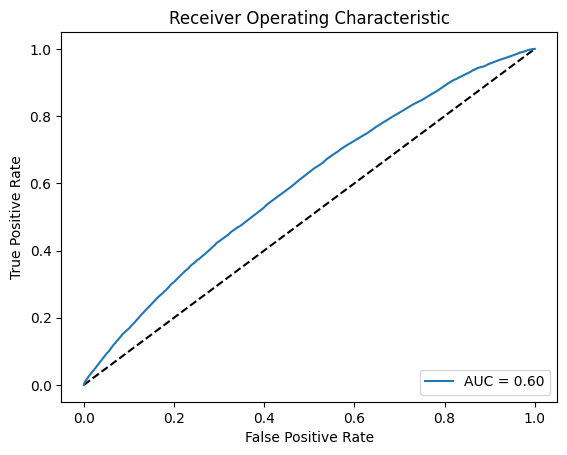

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
# Plot the AUC score
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


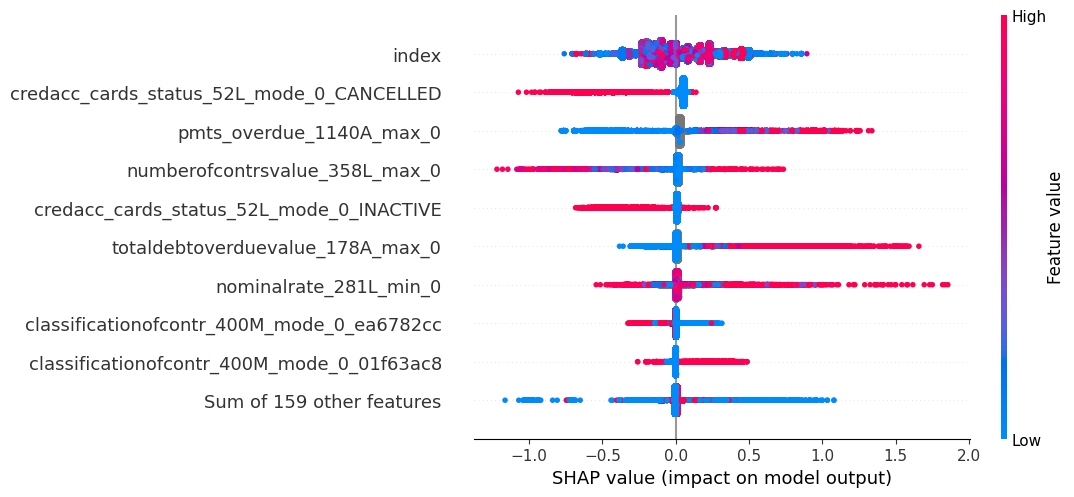

In [9]:
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

invalid value encountered in reduce


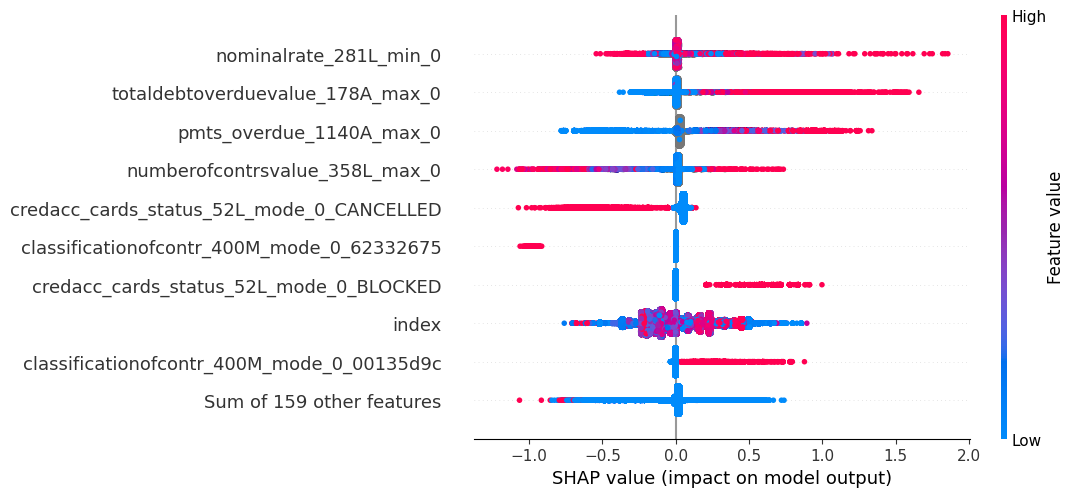

In [11]:
shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0))

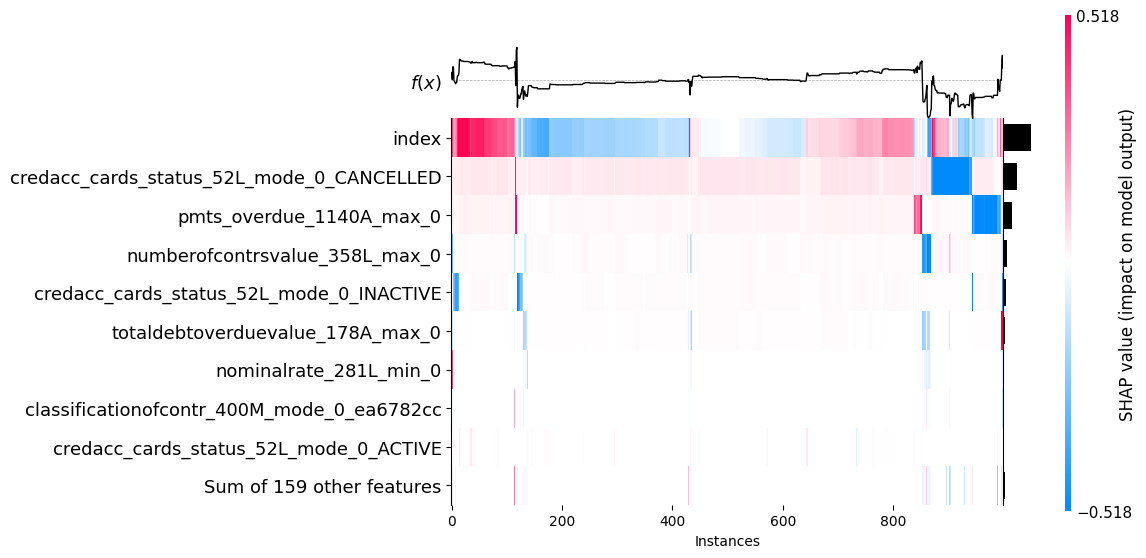

In [12]:
shap.plots.heatmap(shap_values[:1000])

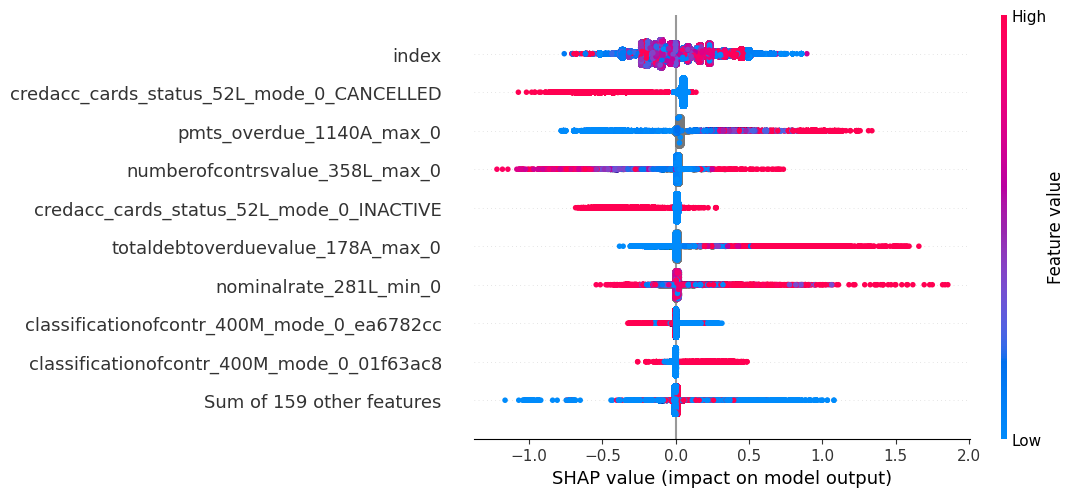

In [13]:
explainer = shap.Explainer(clf)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

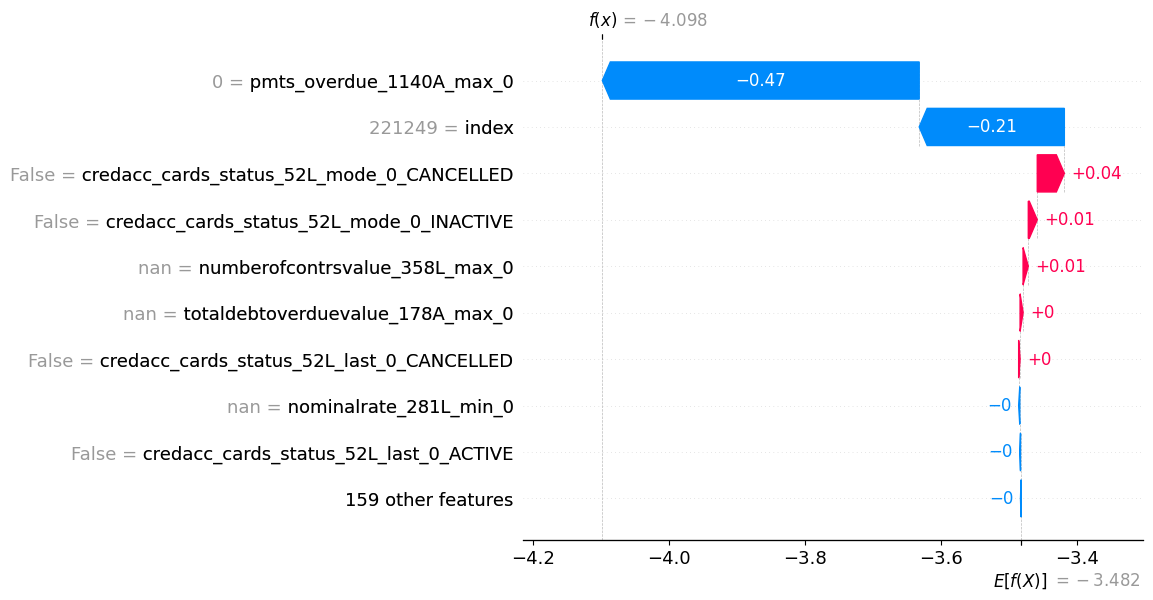

In [15]:
shap.plots.waterfall(shap_values[0])

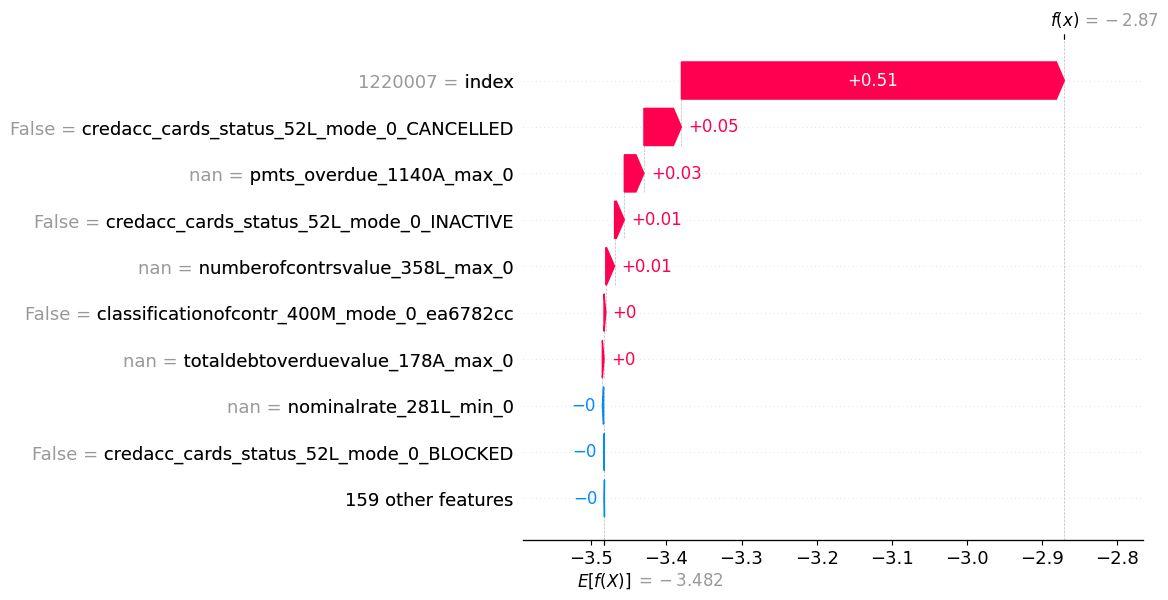

In [17]:
shap.plots.waterfall(shap_values[1])

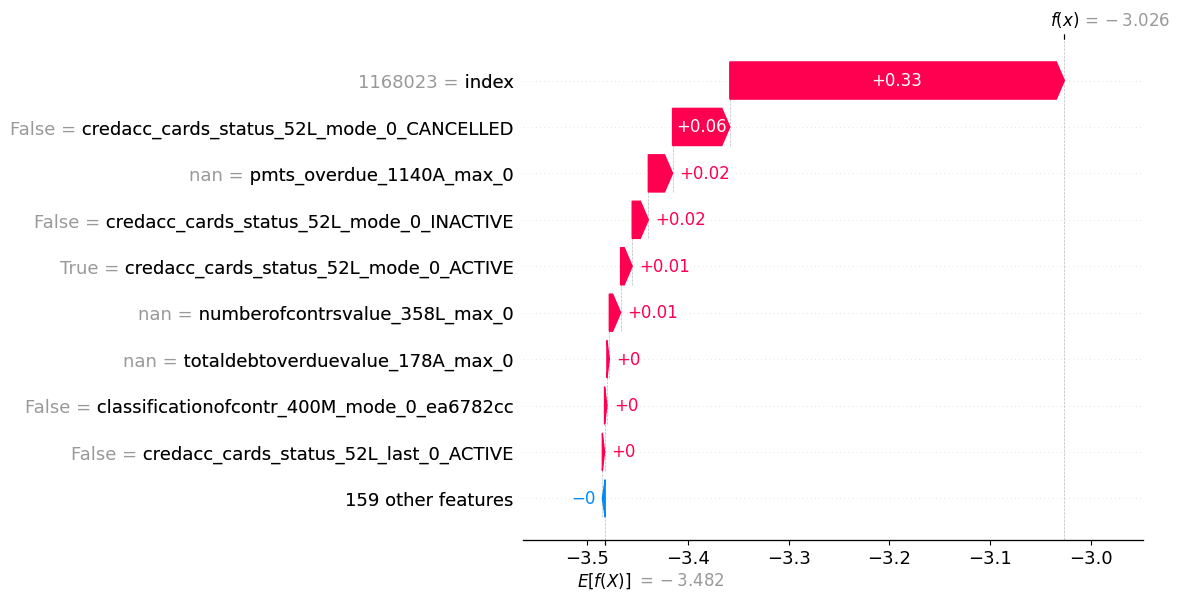

In [19]:
shap.plots.waterfall(shap_values[2])

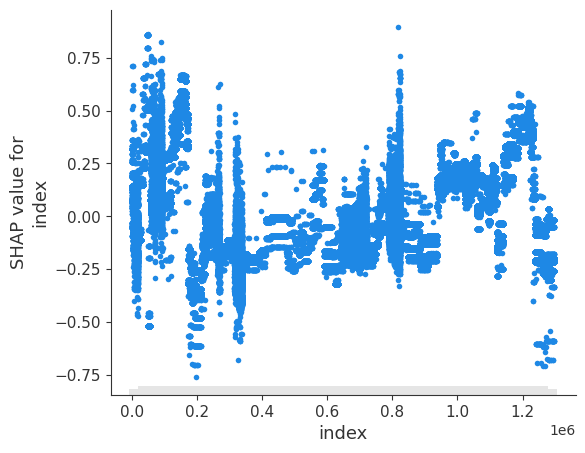

In [21]:
shap.plots.scatter(shap_values[:,"index"])

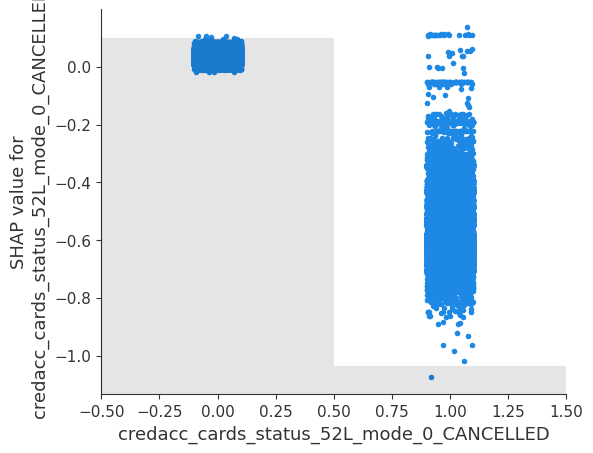

In [20]:
shap.plots.scatter(shap_values[:,"credacc_cards_status_52L_mode_0_CANCELLED"])

All-NaN slice encountered


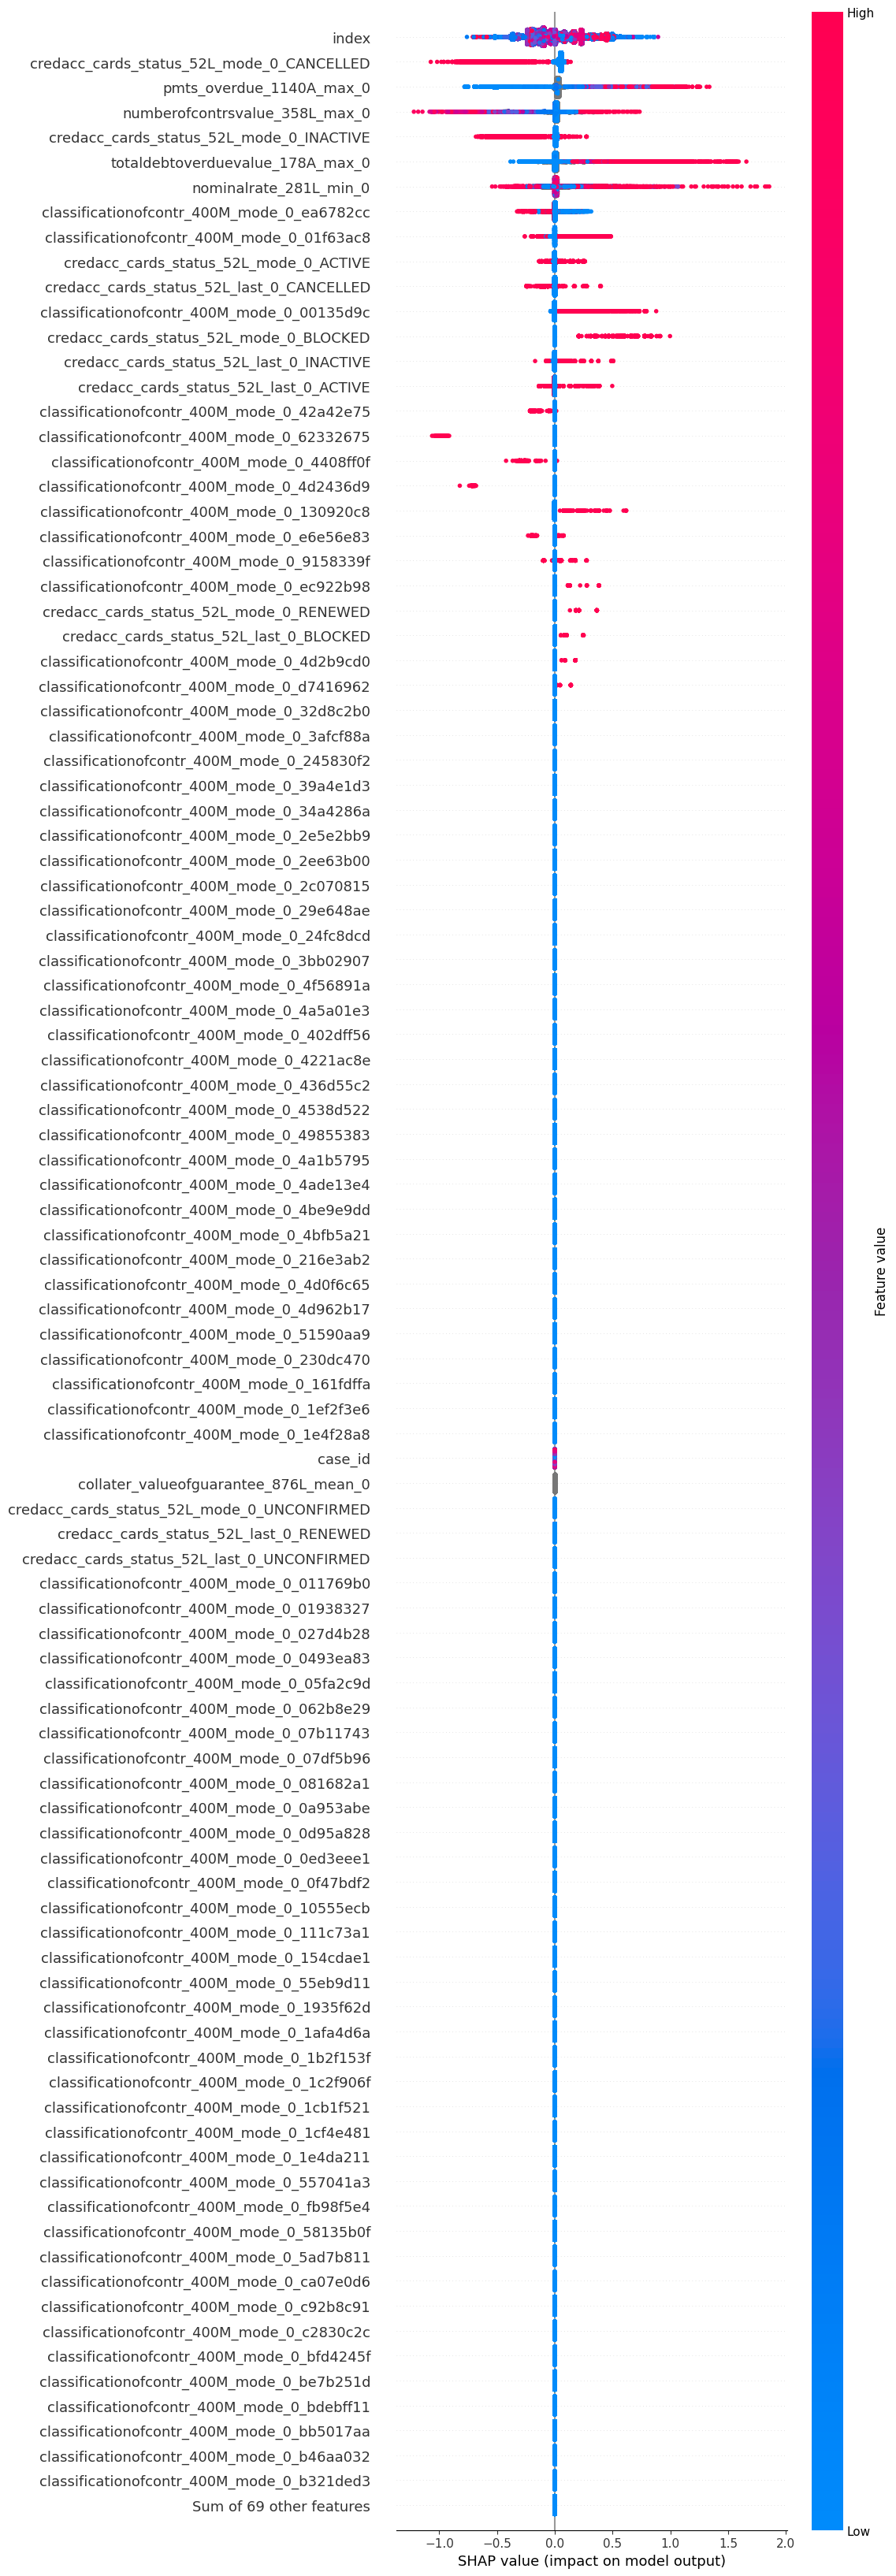

In [23]:
shap.plots.beeswarm(shap_values, max_display=100)